I made a [dataset](https://www.kaggle.com/datasets/shyamgupta196/bone-fracture-split-classification/data) and I  trained the model from it. 

But turns out the results were not what I was expecting ! The Notebook ran for 13 hours and crashed with a GPU ON!!

the results were pretty good. but 13 hours for training an EfficientNetB6 with P100 gpu makes me pretty doubtful. Where Could I have gone wrong. ???? 

These were My WANDB Dashboard results! 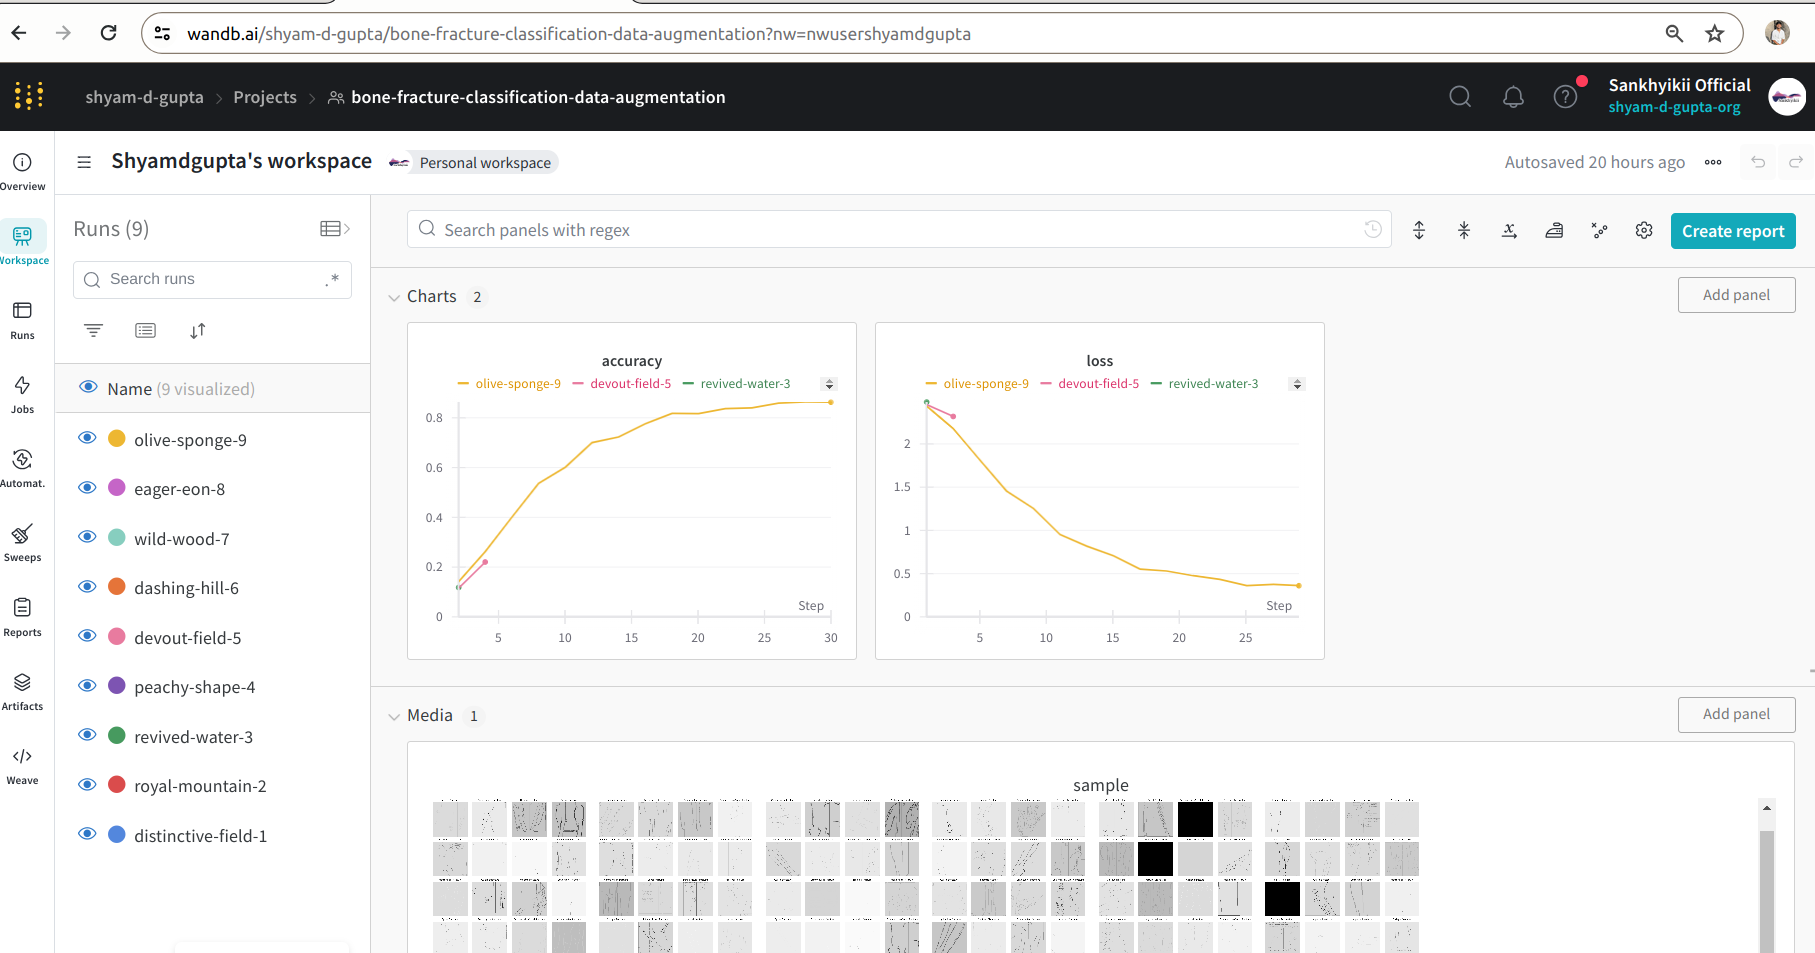

I got pretty good 86% accuracy but I expected it to be faster and better process to make a better pipeline.

## Here's what we are doing!

I wonder If My dataloader is slowing the process, because I am using pretty heavy preprocessing to process my images! **Hence In this Notebook, I will validate all my filters/preprocessing transform classes Individually**


# Lets Start 
Here is my dataloader and dataset class!

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from skimage.restoration import denoise_tv_chambolle
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from tqdm import tqdm

In [2]:
# Define the class labels
class_labels = [
    'Avulsion fracture', 'Compression-Crush fracture', 'Spiral Fracture',
    'Impacted fracture', 'Hairline Fracture', 'Greenstick fracture',
    'Pathological fracture', 'Oblique fracture', 'Fracture Dislocation',
    'Longitudinal fracture', 'Intra-articular fracture', 'Comminuted fracture'
]

# Create a mapping from class name to label index
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_labels)}

class BoneFractureDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for class_name in class_labels:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, image):
        image = np.array(image)
        if image.dtype != np.uint8:
            image = (255 * (image / np.max(image))).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        return Image.fromarray(clahe.apply(image))

class AnisotropicDiffusionTransform:
    def __init__(self, weight=0.1, n_iter=50):
        self.weight = weight
        self.n_iter = n_iter

    def __call__(self, image):
        image = np.array(image)
        diffused = denoise_tv_chambolle(image, weight=self.weight)
        return Image.fromarray((diffused * 255).astype(np.uint8))

class NormalizeTransform:
    def __call__(self, image):
        image = np.array(image)
        normalized = (image - np.mean(image)) / np.std(image)
        return Image.fromarray((normalized * 255).astype(np.uint8))

class ImageSegmentationTransform:
    def __init__(self, method='threshold'):
        self.method = method

    def __call__(self, image):
        image = np.array(image)
        if self.method == 'threshold':
            _, segmented = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif self.method == 'edge_detection':
            segmented = cv2.Canny(image, 50, 120)
        return Image.fromarray(segmented)

# Define a comprehensive transformation pipeline
transform_pipeline = transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    AnisotropicDiffusionTransform(weight=0.6, n_iter=50),
    ImageSegmentationTransform(method='edge_detection'),
    NormalizeTransform(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Convert grayscale to 3 channels
    transforms.Resize((224, 224)),
])


In [3]:
# Sample image for visualization
def samples(path):
    original_image = Image.open(path).convert('L')
    # Apply each transform individually
    clahe_transform = CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))(original_image)
    anisotropic_transform = AnisotropicDiffusionTransform(weight=0.6, n_iter=50)(original_image)
    segmentation_transform = ImageSegmentationTransform(method='edge_detection')(original_image)
    normalize_transform = NormalizeTransform()(original_image)

    # Apply the full transformation pipeline
    transformed_image = transform_pipeline(original_image)

    # Plotting the results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Titles and images
    titles = ['Original Image', 'CLAHE Transform', 'Anisotropic Diffusion',
              'Segmentation', 'Normalization', 'Full Pipeline']

    images = [original_image, clahe_transform, anisotropic_transform, segmentation_transform, normalize_transform, transformed_image]

    # Display the images with titles
    for ax, title, img in zip(axes.flatten(), titles, images):
        if img.mode == 'L':  # Single channel image
            ax.imshow(np.array(img), cmap='gray')
        else:  # 3-channel image
            img = np.array(transforms.Grayscale()(img))
            ax.imshow(np.squeeze(img,axis=0),cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()



/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


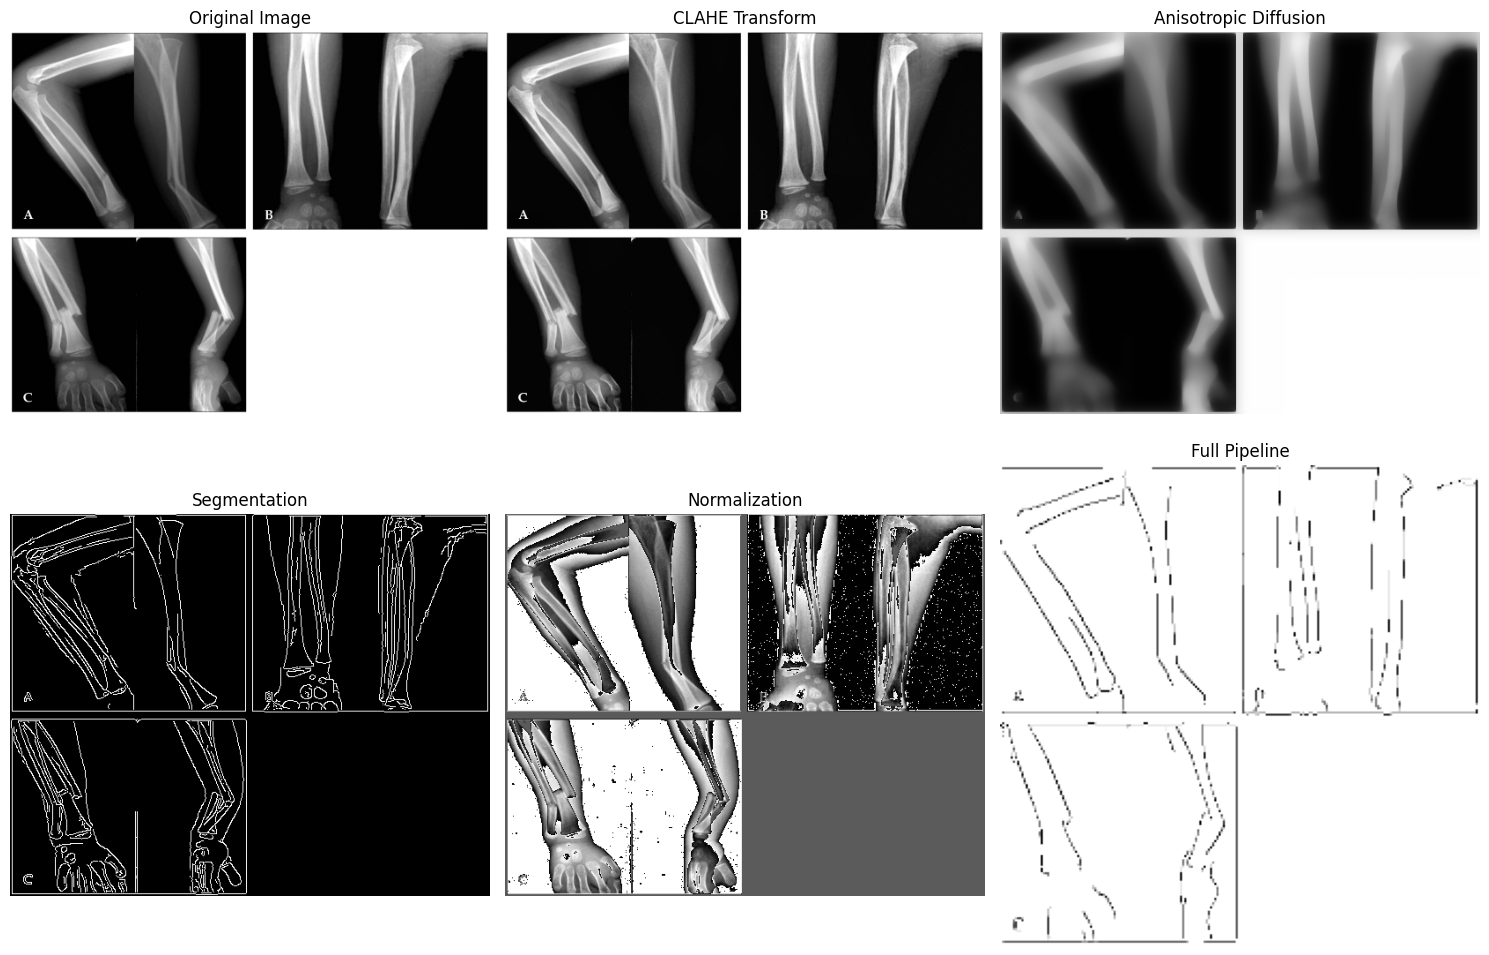

In [4]:

samples('/kaggle/input/bone-fracture-split-classification/train/Greenstick fracture/A-Initial-fracture-radiograph-showing-a-greenstick-fracture-B-Follow-up-radiograph.png')


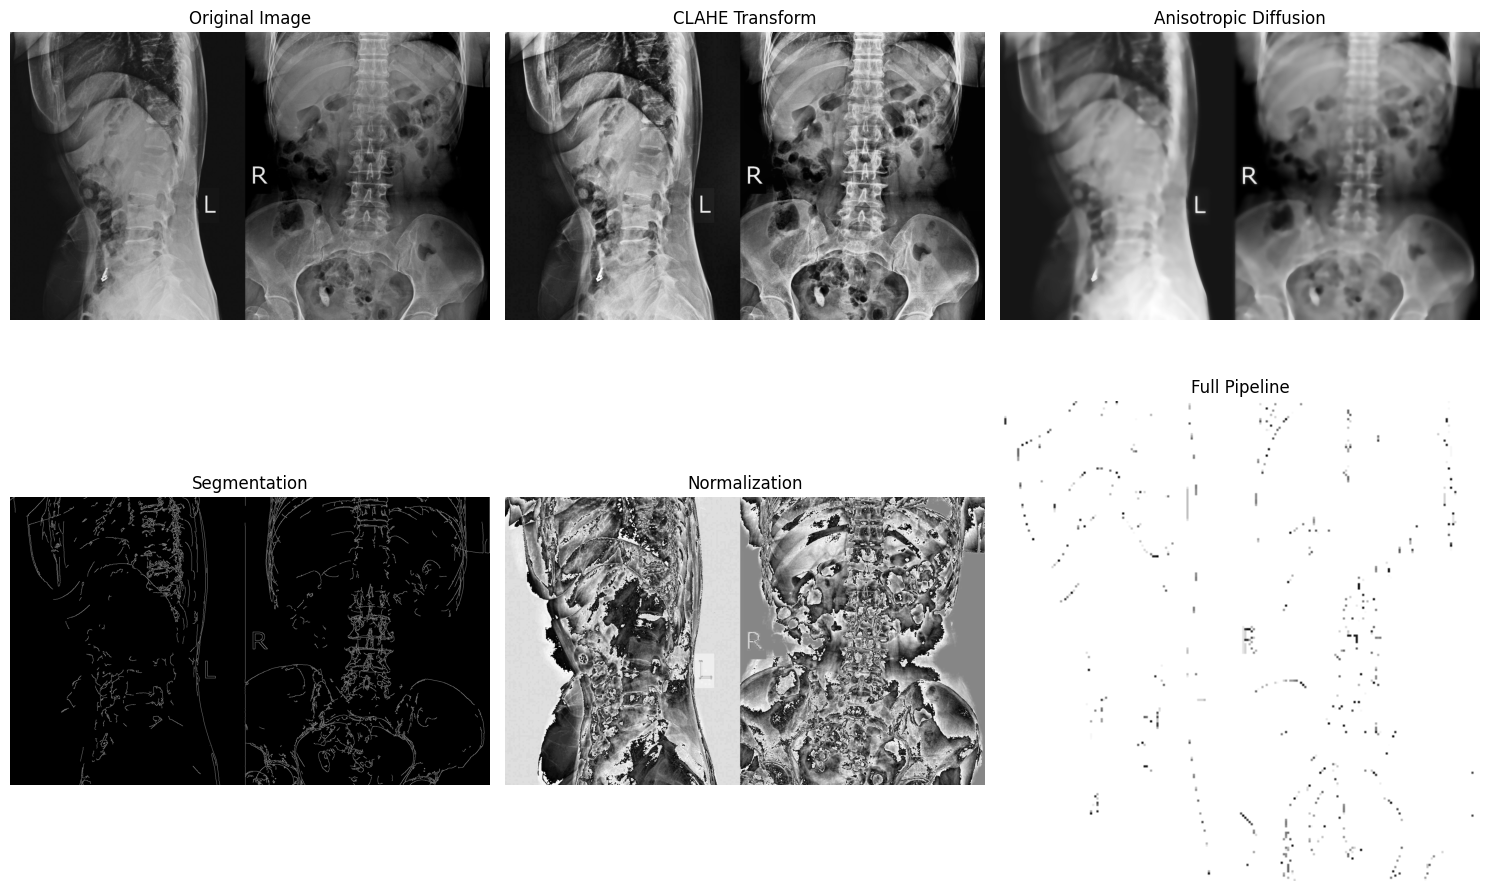

In [5]:
samples('/kaggle/input/bone-fracture-split-classification/train/Impacted fracture/Shanti-Spine_Spinal-Fracture-2000x1200.jpeg')

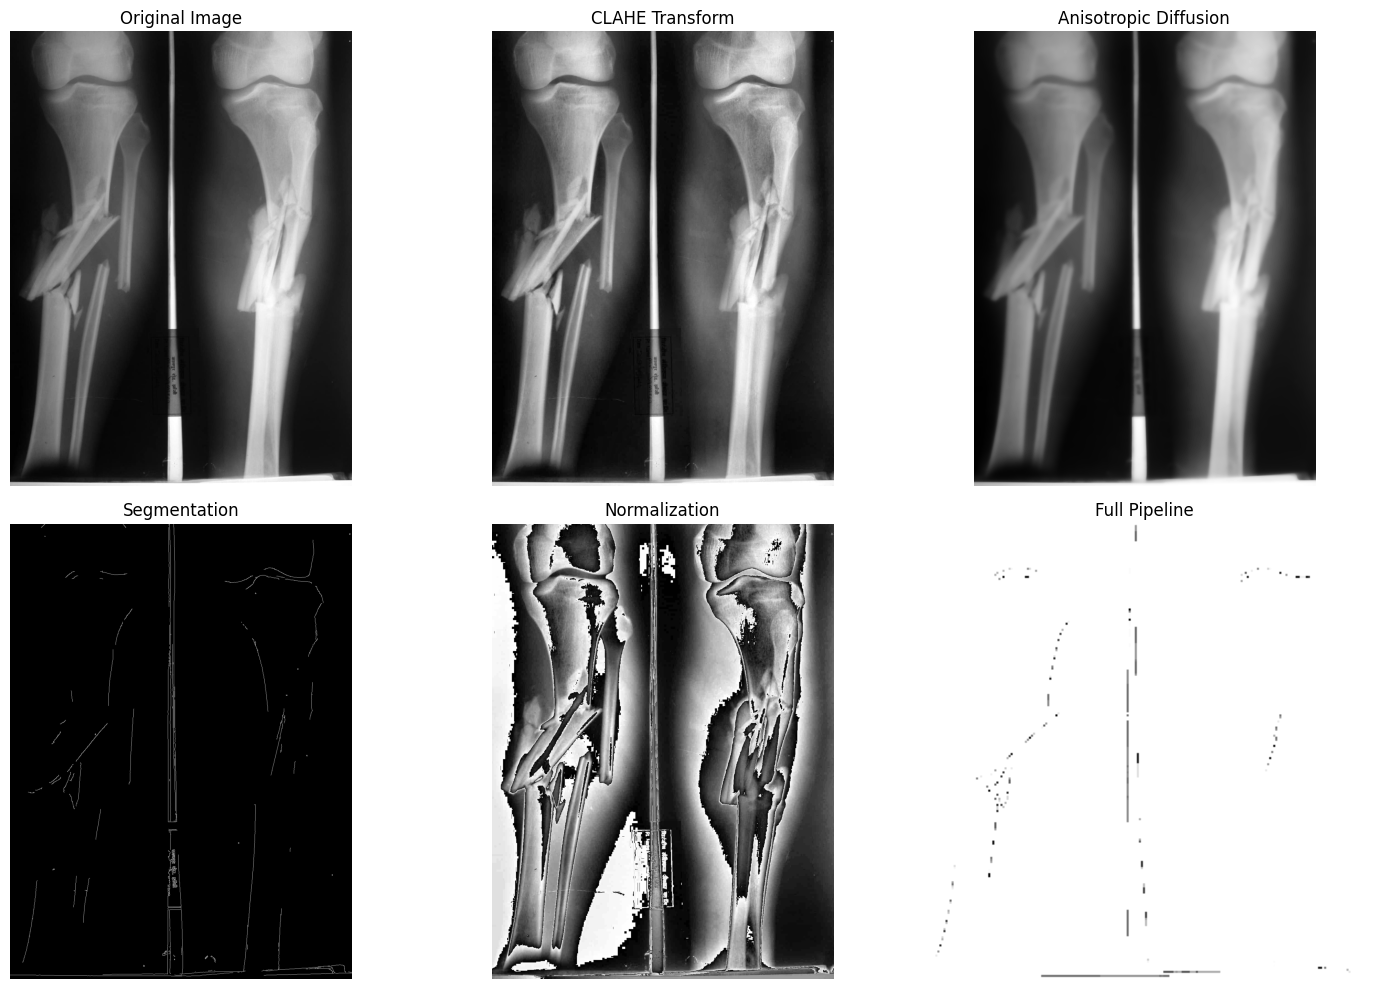

In [6]:
samples('/kaggle/input/bone-fracture-split-classification/test/Comminuted fracture/2.jpg')

# Interesting ! right !

Now In my next training i will probably only use normalization, segmentation, CLAHE to get a better representation ! but definetely not ANISOTROPIC DIFFUSION. because it reduces the clarity of the data! 

Lets go for the training now !

In [7]:

import sys
import wandb
sys.path.append('/kaggle/usr/lib/wandblogin/')
from wandblogin import login
login()
wandb.init(project="bone-fracture-classification-new-augmentation")


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shyamdgupta (shyam-d-gupta). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240607_142537-u5ak0r78
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run prime-valley-3
wandb: ⭐️ View project at https://wandb.ai/shyam-d-gupta/bone-fracture-classification-new-augmentation
wandb: 🚀 View run at https://wandb.ai/shyam-d-gupta/bone-fracture-classification-new-augmentation/runs/

In [8]:
# Define a comprehensive transformation pipeline
transform_pipeline = transforms.Compose([
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
#     AnisotropicDiffusionTransform(weight=0.6, n_iter=50),
#     ImageSegmentationTransform(method='edge_detection'),
    NormalizeTransform(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Convert grayscale to 3 channels
    transforms.Resize((224, 224)),
])


train_dataset = BoneFractureDataset(root_dir='/kaggle/input/bone-fracture-split-classification/train', transform=transform_pipeline)
test_dataset = BoneFractureDataset(root_dir='/kaggle/input/bone-fracture-split-classification/test', transform=transform_pipeline)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
